In [345]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [575]:
def old_state_to_new_state(old_state, wheelbase=0.25):
    x, y, theta = old_state
    rear_x = x - wheelbase / 2 * np.cos(theta)
    rear_y = y - wheelbase / 2 * np.sin(theta)
    front_x = x + wheelbase / 2 * np.cos(theta)
    front_y = y + wheelbase / 2 * np.sin(theta)
    return np.array([rear_x, rear_y, front_x, front_y])

x_s = np.linspace(-4, 4, 25)
y_s = np.linspace(-4, 4, 25)
theta_s = np.linspace(0, 2 * np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T

env = DubinsCarEnv()
state = env.reset()
X = []

for i in range(len(grid)):
    old_state = grid[i]
    new_state = old_state_to_new_state(old_state)
    state = env.set(new_state[0], new_state[1], new_state[2], new_state[3])
    X.append(state)

X_grid = np.array(X)
len(X_grid)


/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


9375

In [576]:
X_grid[1000]

array([[ 1.36114845, -3.21146734],
       [ 1.30551822, -3.45519932]])

In [577]:
X = np.vstack([X_grid])
#np.random.shuffle(X)
#X = np.flip(X,0)
len(X)

9375

In [578]:
pos = np.array([[0.0, -2. ],
       [-.75, -1.75]])
env.step(pos,0)

(array([[ 0.32755757, -2.86444235],
        [-0.60321593, -1.04367154]]),
 0,
 False,
 {'is_legal': True})

In [579]:
X[:,0] - X[:,1]

array([[-0.25      ,  0.        ],
       [-0.22524222, -0.10847093],
       [-0.15587245, -0.19545787],
       ...,
       [-0.15587245,  0.19545787],
       [-0.22524222,  0.10847093],
       [-0.25      ,  0.        ]])

In [580]:
X[ys==-1]

array([[[-4.125     , -4.        ],
        [-3.875     , -4.        ]],

       [[-4.11262111, -4.05423547],
        [-3.88737889, -3.94576453]],

       [[-4.07793623, -4.09772894],
        [-3.92206377, -3.90227106]],

       ...,

       [[ 3.92206377,  4.09772894],
        [ 4.07793623,  3.90227106]],

       [[ 3.88737889,  4.05423547],
        [ 4.11262111,  3.94576453]],

       [[ 3.875     ,  4.        ],
        [ 4.125     ,  4.        ]]])

In [581]:
def plot_surface(X_in, env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    car_centers = np.mean(X_in, axis=1)

    # Plot...
    plt.scatter(car_centers[:, 0], car_centers[:, 1], s=1)  # s is a size of marker
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)

    arrow_len = env.v_max
    front_to_rear = X_in[:, 0] - X_in[:, 1]
    heading_angles = np.arctan2(front_to_rear[:, 1], front_to_rear[:, 0])

    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(heading_angles)
    arrow_dy = arrow_len * np.sin(heading_angles)

    if y_pred:
        arrow_colors = cm.jet((y_pred - np.min(y_pred)) / (np.max(y_pred) - np.min(y_pred)))
    elif len(ys) > 0:
        arrow_colors = cm.get_cmap('jet', 3)(ys + 1)
    else:
        arrow_colors = 'k'

    plt.quiver(car_centers[:, 0], car_centers[:, 1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)

    if file_name:
        plt.savefig(file_name)


In [582]:
ys = [env.get_reward(x) for x in X]
    
ys = np.array(ys)


In [583]:
min(ys)

-1

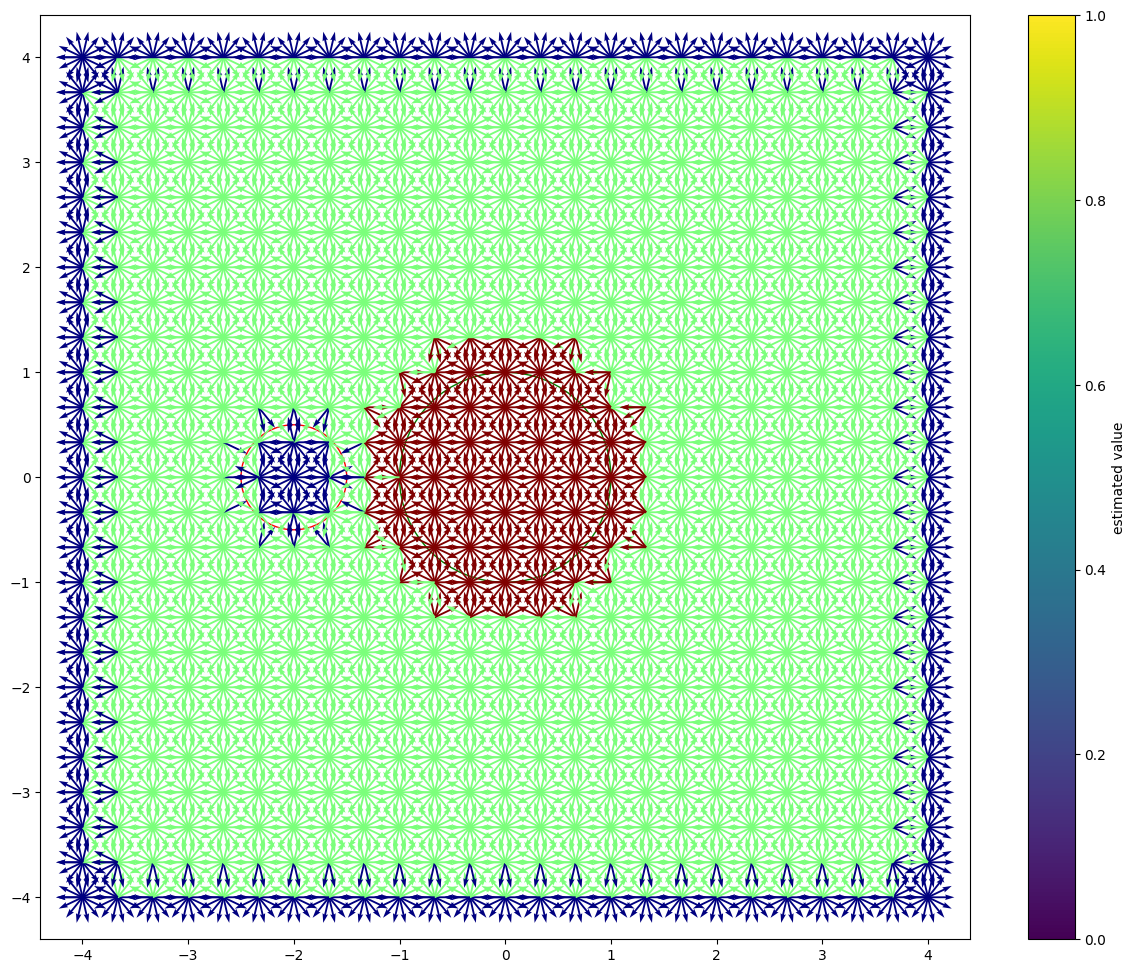

In [584]:
plot_surface(X, env, None, None, ys)

In [428]:


plot_surface(X_val, env, ys=[])

NameError: name 'X_val' is not defined

In [158]:
x_mean = np.mean(X_grid[:, 0])
x_std = np.std(X_grid[:, 0])
y_mean = np.mean(X_grid[:, 1])
y_std = np.std(X_grid[:, 1])


def normalize(X):
    X[:, 0] = (X[:, 0] - x_mean) / x_std
    X[:, 1] = (X[:, 1] - y_mean) / y_std
    return X

#X = normalize(X)

In [159]:
X3 = X.copy()
X_val3 = X_val.copy()
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X_val = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))




In [160]:
X

array([[-4.00000000e+00, -4.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-4.00000000e+00, -4.00000000e+00,  9.00968868e-01,
         4.33883739e-01],
       [-4.00000000e+00, -4.00000000e+00,  6.23489802e-01,
         7.81831482e-01],
       ...,
       [ 4.00000000e+00,  4.00000000e+00,  6.23489802e-01,
        -7.81831482e-01],
       [ 4.00000000e+00,  4.00000000e+00,  9.00968868e-01,
        -4.33883739e-01],
       [ 4.00000000e+00,  4.00000000e+00,  1.00000000e+00,
        -2.44929360e-16]])

In [170]:

def forward(X):
    l1 = hk.Linear(128)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(128)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(128)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

# @jax.jit
# def loss_fn(params, X, y):
#     err = forward(params, X) - y
#     return jnp.mean(jnp.square(err))  # mse


l2_reg_strength = 1e-4  # Adjust this to control the strength of regularization

def l2_regularization(params):
    l2_loss = 0.0
    for param in jax.tree_leaves(params):
        if param.ndim > 1:
            l2_loss += jnp.sum(jnp.square(param))
    return l2_loss

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    mse_loss = jnp.mean(jnp.square(err))
    l2_loss = l2_reg_strength * l2_regularization(params)
    return mse_loss + l2_loss



optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.8

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = True

for epoch in range(100):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


/tmp/ipykernel_3654102/3303103726.py:35: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  for param in jax.tree_leaves(params):


epoch 0 average loss 0.11854396 epoch delta inf
epoch 1 average loss 0.083749644 epoch delta 0.034794316
epoch 2 average loss 0.081574656 epoch delta 0.0021749884
epoch 3 average loss 0.07373762 epoch delta 0.007837035
epoch 4 average loss 0.069426246 epoch delta 0.0043113753
epoch 5 average loss 0.06495849 epoch delta 0.0044677556
epoch 6 average loss 0.061741874 epoch delta 0.0032166168
epoch 7 average loss 0.058662813 epoch delta 0.0030790605
epoch 8 average loss 0.056213867 epoch delta 0.0024489462
epoch 9 average loss 0.054252163 epoch delta 0.0019617043
epoch 10 average loss 0.052777983 epoch delta 0.0014741793
epoch 11 average loss 0.05168168 epoch delta 0.0010963045
epoch 12 average loss 0.05084209 epoch delta 0.0008395873
epoch 13 average loss 0.050059196 epoch delta 0.00078289583
epoch 14 average loss 0.04936461 epoch delta 0.0006945841
epoch 15 average loss 0.04874571 epoch delta 0.0006189011
epoch 16 average loss 0.048241824 epoch delta 0.0005038865
epoch 17 average loss 0.

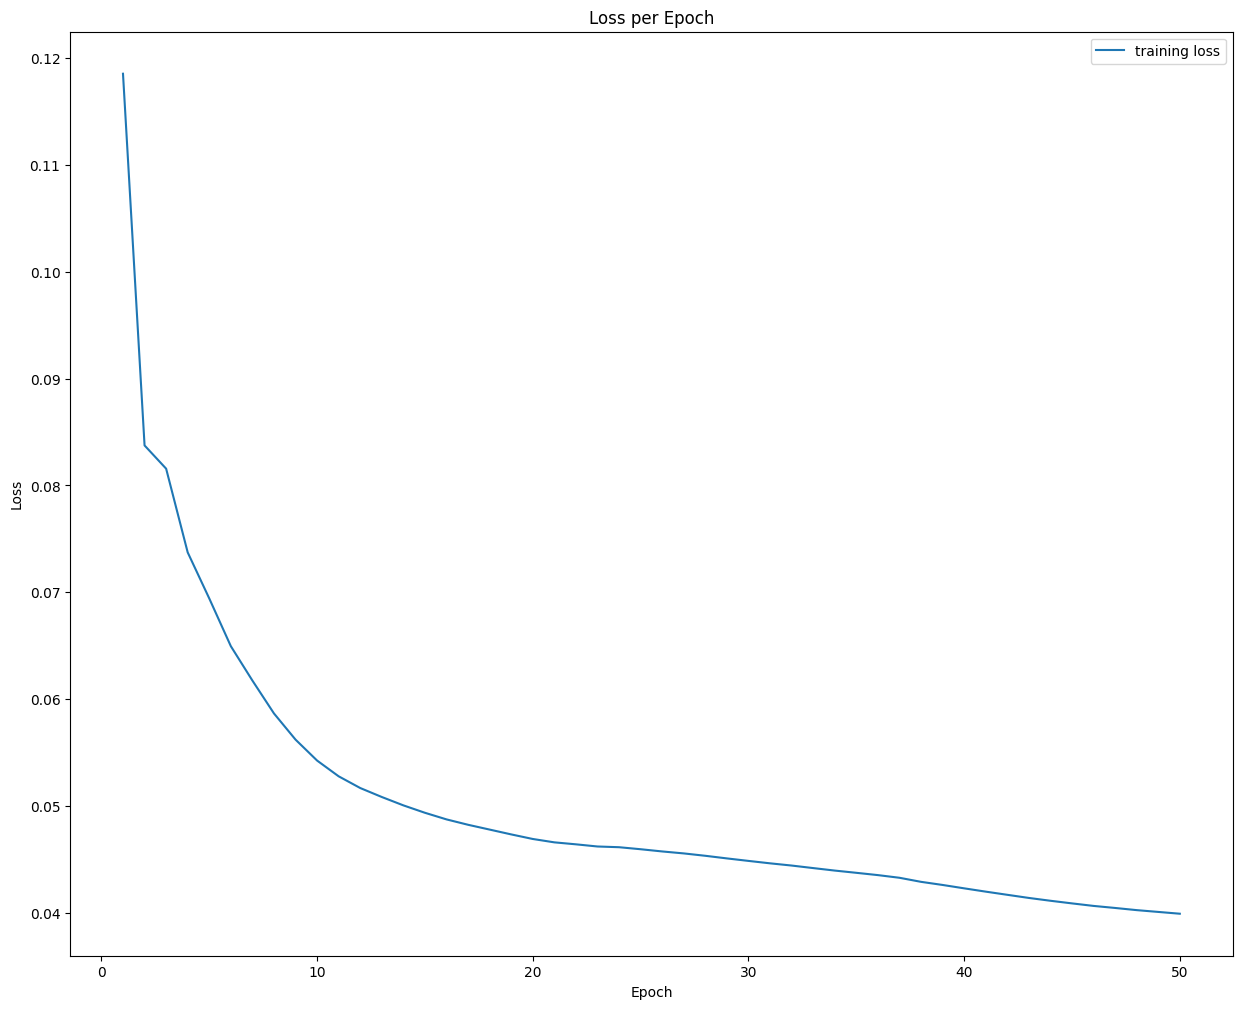

In [162]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
#vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
#plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [163]:
#generate data

x_s = np.linspace(-5,5, 20)
y_s = np.linspace(-5,5, 20)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_test = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_test = []
for i in range(len(grid_test)):
    state = env.set(grid_test[i][0], grid_test[i][1], grid_test[i][2])
    X_test.append(state)

X_test = np.array(X_test)

X_test_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_test)))
#X_text_encoded = normalize(X_test_encoded)
X_test_encoded

array([[-5.00000000e+00, -5.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-5.00000000e+00, -5.00000000e+00,  9.00968868e-01,
         4.33883739e-01],
       [-5.00000000e+00, -5.00000000e+00,  6.23489802e-01,
         7.81831482e-01],
       ...,
       [ 5.00000000e+00,  5.00000000e+00,  6.23489802e-01,
        -7.81831482e-01],
       [ 5.00000000e+00,  5.00000000e+00,  9.00968868e-01,
        -4.33883739e-01],
       [ 5.00000000e+00,  5.00000000e+00,  1.00000000e+00,
        -2.44929360e-16]])

In [171]:



y_pred = [forward(X=x, params=params) for x in X_test_encoded]

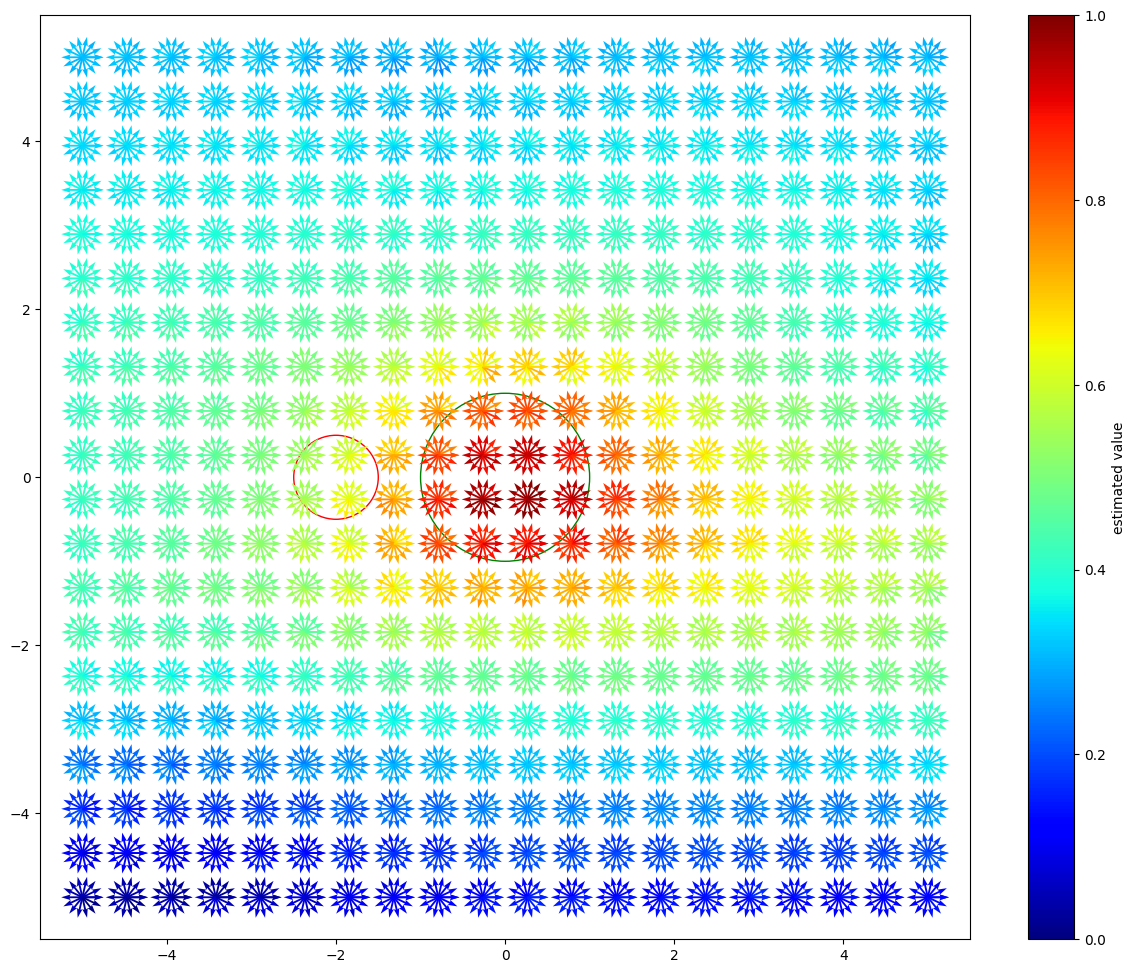

In [172]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [173]:
y_train = [forward(X=x, params=params) for x in X]

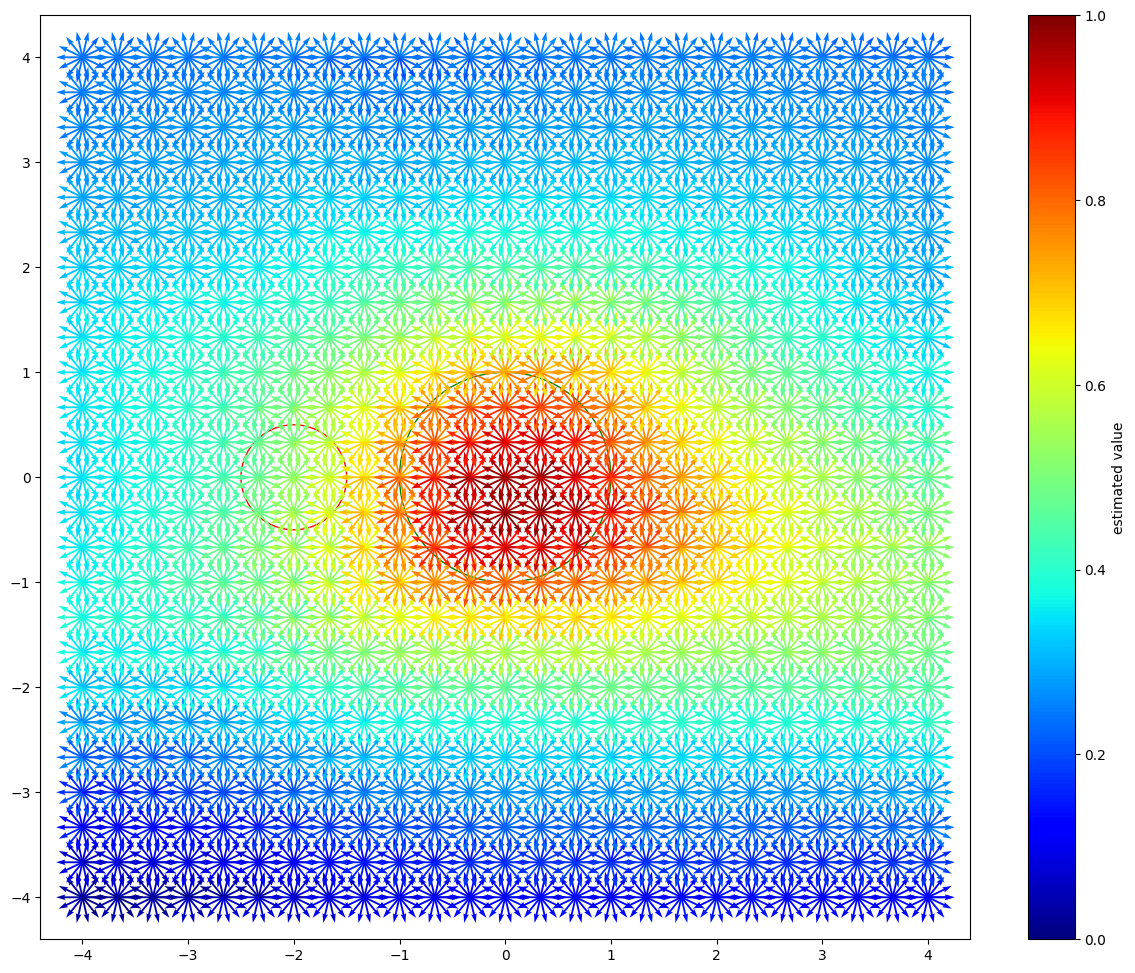

In [174]:
plot_surface(X3, env, 'experiment.png', y_train)

In [179]:
#train on small steps, run on bigger steps?
right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-3.9,-3.9, up)
#state = env.reset()

gamma = gamma
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, info = env.step(state, a, update_env=False)


        if info['is_legal']:
            estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)
            value = reward + gamma*estimate[0]
            possible_actions.append(value)
        else:
            possible_actions.append(-np.inf)

    print(possible_actions)
    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
    
env.make_gif()

[Array(-0.19741069, dtype=float32), Array(-0.16031922, dtype=float32), -inf]
1
[Array(-0.1623875, dtype=float32), Array(-0.1288733, dtype=float32), -inf]
2
[Array(-0.14629662, dtype=float32), Array(-0.09280137, dtype=float32), -inf]
3
[Array(-0.12062545, dtype=float32), Array(-0.06140415, dtype=float32), -inf]
4
[Array(-0.08132228, dtype=float32), Array(-0.02635226, dtype=float32), -inf]
5
[Array(-0.0322419, dtype=float32), Array(0.0098683, dtype=float32), -inf]
6
[Array(0.01006032, dtype=float32), Array(0.0460726, dtype=float32), -inf]
7
[Array(0.04699951, dtype=float32), Array(0.08160431, dtype=float32), -inf]
8
[Array(0.08481767, dtype=float32), Array(0.11419471, dtype=float32), -inf]
9
[Array(0.11284085, dtype=float32), Array(0.1426463, dtype=float32), -inf]
10
[Array(0.13049252, dtype=float32), Array(0.15197735, dtype=float32), -inf]
11
[Array(0.1406344, dtype=float32), Array(0.13802901, dtype=float32), -inf]
12
[Array(0.14495775, dtype=float32), Array(0.15629461, dtype=float32), 

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([-4,-4,1, 1]), params=params) 

Array([1.237214], dtype=float32)

In [ ]:
forward(X=np.array([0,0,1, 0]), params=params) 

Array([0.08173393], dtype=float32)

In [ ]:
env.step(np.array([0,0,np.pi]), 0, update_env=False)

(array([2.50000000e-01, 4.37113883e-08, 2.00712864e+00]), 100, True, {})

In [ ]:
X[0]

array([ 1.8830727 , -1.7482759 ,  0.23815954, -0.97122604], dtype=float32)

In [ ]:
try 90 degree turns first, try dropout or batch norm, standaridse all states, if relu add non trainable params 